In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import tensorflow as tf

from tensorflow.keras.preprocessing import image
from skimage.transform import resize
from skimage.util import img_as_ubyte

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD


In [3]:
!wget -nc https://lazyprogrammer.me/course_files/charmander-tight.png

--2020-08-19 17:38:15--  https://lazyprogrammer.me/course_files/charmander-tight.png
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.31.80.48, 104.31.81.48, 172.67.213.166, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.31.80.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3952 (3.9K) [image/png]
Saving to: ‘charmander-tight.png’

charmander-tight.pn 100%[===================>]   3.86K  --.-KB/s    in 0s      

2020-08-19 17:38:16 (44.1 MB/s) - ‘charmander-tight.png’ saved [3952/3952]



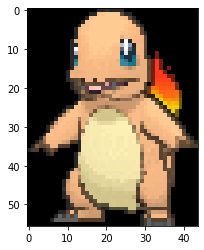

In [4]:
ch = image.load_img('charmander-tight.png')
plt.imshow(ch)
plt.show()

In [5]:
type(ch)

PIL.Image.Image

In [6]:
IMG_SIZE = 200
ch = np.array(ch)
CH_H, CH_W, _ = ch.shape

def pokemon_generator_with_resize(batch_size=5):
  while True:
      X = np.zeros((batch_size, IMG_SIZE, IMG_SIZE, 3))
      Y = np.zeros((batch_size, 4))

      for i in range(batch_size):
        # resize charmander
        scale = 0.5 + np.random.random()
        CH_H_new = int(scale * CH_H)
        CH_W_new = int(scale * CH_W)
        ch_new = img_as_ubyte(resize(ch, (CH_H_new, CH_W_new)))

        # locate the region for charmander
        row0 = np.random.randint(IMG_SIZE - CH_H_new)
        col0 = np.random.randint(IMG_SIZE - CH_W_new)
        row1 = row0 + CH_H_new
        col1 = col0 + CH_W_new
        
        # place charmander in
        X[i, row0:row1, col0:col1, :] = ch_new[:,:,:]
        Y[i, 0] = row0 / IMG_SIZE
        Y[i, 1] = col0 / IMG_SIZE
        Y[i, 2] = (row1 - row0) / IMG_SIZE
        Y[i, 3] = (col1 - col0) / IMG_SIZE

      yield X / 255.0, Y

In [26]:
def make_model():
  vgg = tf.keras.applications.VGG16(
      input_shape=[IMG_SIZE, IMG_SIZE, 3], 
      include_top=False, 
      weights='imagenet')
  x = Flatten()(vgg.output)
  x = Dense(4, activation='sigmoid')(x)
  model = Model(vgg.input, x)

  model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))

  return model

In [27]:
model = make_model()
model.fit(
    pokemon_generator_with_resize(),
    steps_per_epoch=100,
    epochs=5
)

Epoch 1/5
100/100 [==============================] - 9s 89ms/step - loss: 0.0176
Epoch 2/5
100/100 [==============================] - 9s 91ms/step - loss: 0.0053
Epoch 3/5
100/100 [==============================] - 9s 92ms/step - loss: 0.0067
Epoch 4/5
100/100 [==============================] - 9s 92ms/step - loss: 0.0019
Epoch 5/5
100/100 [==============================] - 9s 92ms/step - loss: 0.0010


In [28]:
def pokemon_prediction_with_resize():
  # resize charmander
  scale = 0.5 + np.random.random()
  CH_H_new = int(scale * CH_H)
  CH_W_new = int(scale * CH_W)
  ch_new = img_as_ubyte(resize(ch, (CH_H_new, CH_W_new)))

  # generate a random image
  x = np.zeros((IMG_SIZE, IMG_SIZE, 3))
  row0 = np.random.randint(IMG_SIZE - CH_H_new)
  col0 = np.random.randint(IMG_SIZE - CH_W_new)
  row1 = row0 + CH_H_new
  col1 = col0 + CH_W_new

  x[row0:row1, col0:col1, :] = ch_new[:,:,:]
  print("True:", [row0, col0, row1, col1])

  # Predict
  X = np.expand_dims(x, 0) / 255.0
  p = model.predict(X)[0]
  print((p*IMG_SIZE).astype(int).tolist())
  
  # Draw the box
  fig, ax = plt.subplots(1)
  ax.imshow(x.astype(np.uint8))
  rect = Rectangle(
      (p[1]*IMG_SIZE, p[0]*IMG_SIZE),
      p[3]*IMG_SIZE, 
      p[2]*IMG_SIZE, 
      linewidth=1, 
      edgecolor='r', 
      facecolor='none')
  ax.add_patch(rect)
  plt.show()

True: [137, 66, 178, 98]
[143, 71, 35, 27]


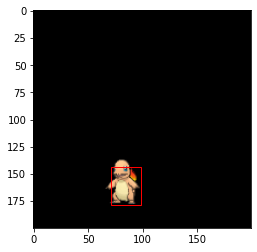

In [62]:
pokemon_prediction_with_resize()